## Exercise 4 - Task 3 - Training a Variational Autoencoder on MNIST

tensorflow 1.13

Imports

In [1]:
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tfd = tf.contrib.distributions

C:\Users\golde\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\golde\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\golde\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\golde\Anaconda3\envs\tensorflow1\lib\site-pack


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Load MNIST, divide into train & test sets, and normalize data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

image_size = X_train.shape[1]
original_dim = image_size * image_size

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

Network parameters

In [3]:
hidden_dim = 256
code_size = 2
epochs = 60
batch_size = 128
learning_rate = 0.001

Plotting

In [4]:
black_background = 'Greys_r'
white_background = 'gray_r'

#Latent code color-coded by label and decoded samples from the prior
def plot(epoch, codes, labels, samples, size = 1):
    ig, ax = plt.subplots(ncols = 1 + len(samples), figsize = ((1 + len(samples)) * size, size))
    no_ticks = dict(left = 'off', bottom = 'off', labelleft = 'off', labelbottom = 'off')
    ax[0].scatter(codes[:, 0], codes[:, 1], s = 2, c = labels, alpha = 0.1)
    ax[0].set_aspect('equal')
    ax[0].set_xlim(codes.min() - .1, codes.max() + .1)
    ax[0].set_ylim(codes.min() - .1, codes.max() + .1)
    ax[0].tick_params(axis='both', which='both', **no_ticks)
    for index, sample in enumerate(samples):
        ax[1 + index].imshow(sample, cmap = black_background)
        ax[1 + index].tick_params(axis = 'both', which = 'both', **no_ticks)
    plt.show()
    
#Latent code color-coded by label
def plot_latent(epoch, codes, labels, size = 8):
    ig, ax = plt.subplots(ncols = 1, figsize = (size, size))
    no_ticks = dict(left = 'off', bottom = 'off', labelleft = 'off', labelbottom = 'off')
    ax.set_xlabel('latent variable 1')
    ax.set_ylabel('latent variable 2')
    ax.scatter(codes[:, 0], codes[:, 1], s = 2, c = labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(axis = 'both', which = 'both', **no_ticks)
    plt.show()
    
#Digits
def plot_digits(digits, size = 1):
    ig, ax = plt.subplots(ncols=len(digits), figsize=(len(digits) * size, size))
    no_ticks = dict(left = 'off', bottom = 'off', labelleft = 'off', labelbottom = 'off')
    for index, digit in enumerate(digits):
        ax[index].imshow(digit, cmap = black_background)
        ax[index].tick_params(axis = 'both', which = 'both', **no_ticks)
    plt.show()

#Loss curve
def plot_loss_curve():
    plt.figure(figsize=(16,10), dpi= 50)
    plt.plot(range(len(elbos)), elbos, color='tab:red')
    plt.xlabel('epoch')
    plt.ylabel('-L_ELBO')
    plt.show()

Encoder

In [5]:
def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x_1 = tf.layers.dense(x, hidden_dim, tf.nn.relu)
    x_2 = tf.layers.dense(x_1, hidden_dim, tf.nn.relu)
    #the mean is unconstrained
    loc = tf.layers.dense(x_2, code_size)
    #the standard deviation must be positive: softplus
    scale = tf.layers.dense(x_2, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)

Prior

In [6]:
def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)

Decoder

In [7]:
def make_decoder(code, data_shape):
    x = code
    x_1 = tf.layers.dense(x, hidden_dim, tf.nn.relu)
    x_2 = tf.layers.dense(x_1, hidden_dim, tf.nn.relu)
    loc = tf.layers.dense(x_2, np.prod(data_shape), tf.nn.tanh)
    scale = tf.layers.dense(x_2, np.prod(data_shape), tf.nn.softmax)
    return loc, scale

Reuse Model

In [8]:
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

Define Model & Loss

In [9]:
data = tf.placeholder(tf.float32, [None, image_size, image_size])

# Define Model
prior = make_prior(code_size)
posterior = make_encoder(data, code_size)
code = posterior.sample()

# Define Loss
loc, scale = make_decoder(code, [image_size, image_size])
multi_var_n = tfd.MultivariateNormalDiag(loc, scale)

likelihood = multi_var_n.log_prob(tf.reshape(data, [-1, original_dim]))
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(learning_rate).minimize(-elbo)

3. Train VAE

In [10]:
samples, _ = make_decoder(prior.sample(15), [image_size, image_size])

elbos, codes, reconstructed, generated = ([] for i in range(4))
loc_shape = (-1, image_size, image_size)
selected_epochs = [1, 5, 25, 50]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        test_elbo, test_codes, test_samples, test_loc = sess.run([elbo, code, samples, loc], {data: X_test})
        elbos.append(test_elbo)
        print('Epoch', epoch, '/', epochs, 'ELBO', test_elbo)
        test_samples = test_samples.reshape(loc_shape)
        
        for e in selected_epochs:
            if epoch == e:
                codes.append(test_codes)
                reconstructed.append(test_loc.reshape(loc_shape))
                generated.append(test_samples)

        for _ in range(600):
            digits = np.random.choice(X_train.shape[0], batch_size)
            batch = X_train[digits]
            sess.run(optimize, {data: batch})

Epoch 0 / 60 ELBO -27665046.0
Epoch 1 / 60 ELBO -3497770.2
Epoch 2 / 60 ELBO -3102900.2
Epoch 3 / 60 ELBO -2869234.5
Epoch 4 / 60 ELBO -2691637.8
Epoch 5 / 60 ELBO -2644960.0
Epoch 6 / 60 ELBO -2552644.5
Epoch 7 / 60 ELBO -2499017.0
Epoch 8 / 60 ELBO -2415966.2
Epoch 9 / 60 ELBO -2405521.5
Epoch 10 / 60 ELBO -2359742.0
Epoch 11 / 60 ELBO -2343324.5
Epoch 12 / 60 ELBO -2333305.8
Epoch 13 / 60 ELBO -2295148.5
Epoch 14 / 60 ELBO -2250336.8
Epoch 15 / 60 ELBO -2216185.5
Epoch 16 / 60 ELBO -2219308.8
Epoch 17 / 60 ELBO -2218201.8
Epoch 18 / 60 ELBO -2195652.8
Epoch 19 / 60 ELBO -2185005.0
Epoch 20 / 60 ELBO -2188074.5
Epoch 21 / 60 ELBO -2186182.0
Epoch 22 / 60 ELBO -2176084.2
Epoch 23 / 60 ELBO -2148536.0
Epoch 24 / 60 ELBO -2190821.2
Epoch 25 / 60 ELBO -2222260.8
Epoch 26 / 60 ELBO -2197096.0
Epoch 27 / 60 ELBO -2258063.5
Epoch 28 / 60 ELBO -2200454.5
Epoch 29 / 60 ELBO -2188412.0
Epoch 30 / 60 ELBO -2197286.0
Epoch 31 / 60 ELBO -2109886.8
Epoch 32 / 60 ELBO -2188527.2
Epoch 33 / 60 ELBO 

3. (a) Plot of the latent representations

Epoch 1


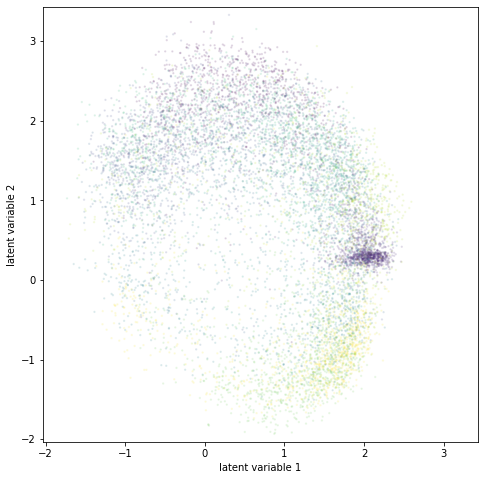

Epoch 5


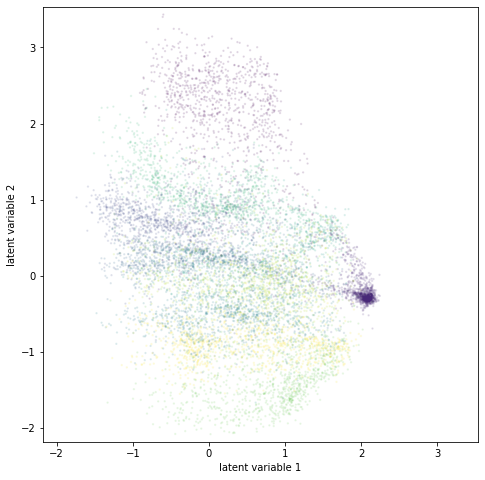

Epoch 25


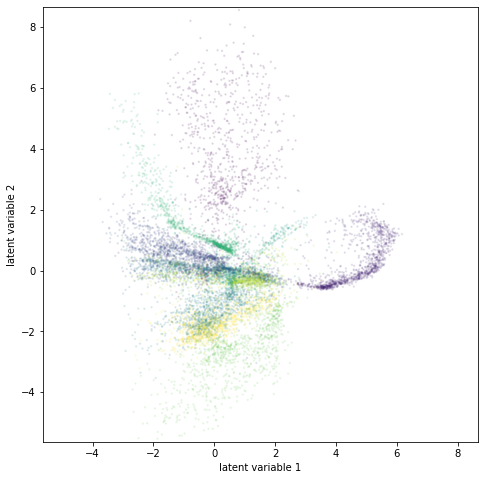

Epoch 50


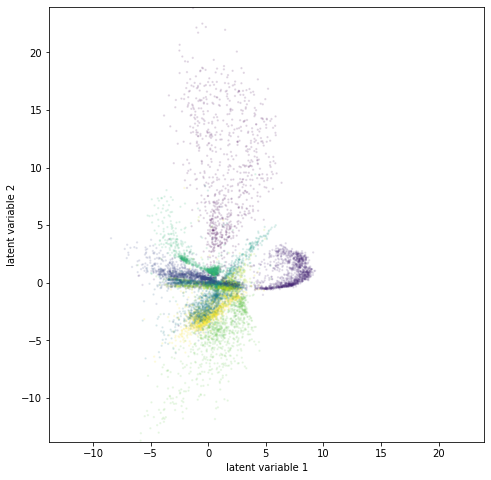

In [11]:
for e in selected_epochs:
    print('Epoch', e)
    plot_latent(e, codes[selected_epochs.index(e)], y_test)

3. (b) Plot of 15 reconstructed digits and the original ones

Epoch 1


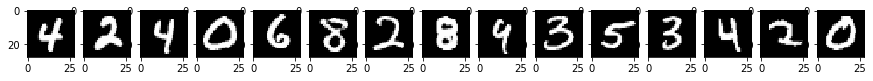

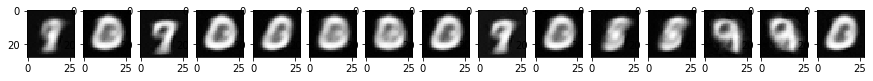

Epoch 5


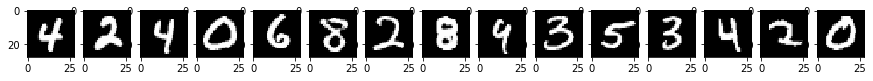

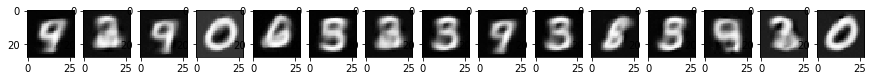

Epoch 25


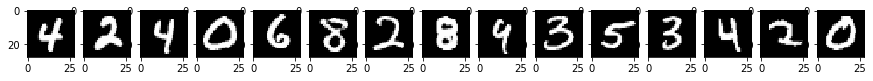

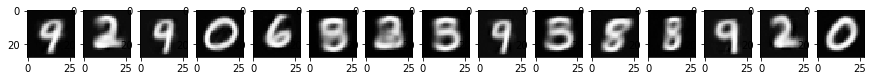

Epoch 50


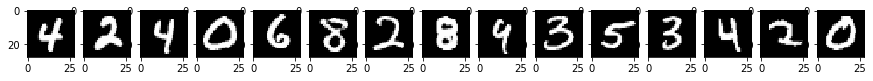

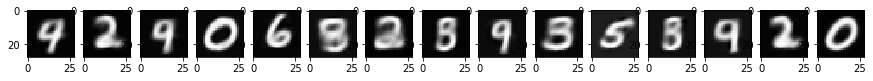

In [12]:
#randomly selecting 15 unique digits from test set
digits = np.random.choice(X_test.shape[0], 15, replace=False)

for e in selected_epochs:
    print('Epoch', e)
    plot_digits(X_test[digits])
    plot_digits(reconstructed[selected_epochs.index(e)][digits])

3. (c) Plot of 15 generated digits

Epoch 1


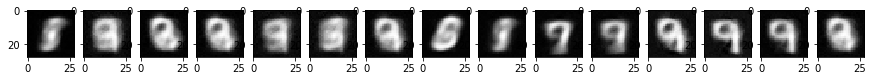

Epoch 5


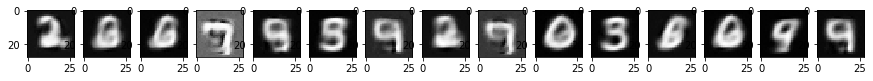

Epoch 25


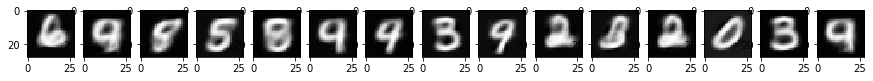

Epoch 50


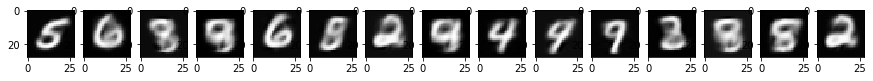

In [13]:
for e in selected_epochs:
    print('Epoch', e)
    plot_digits(generated[selected_epochs.index(e)])

4. Loss curve: epoch vs. $-\mathcal{L}_{ELBO}$

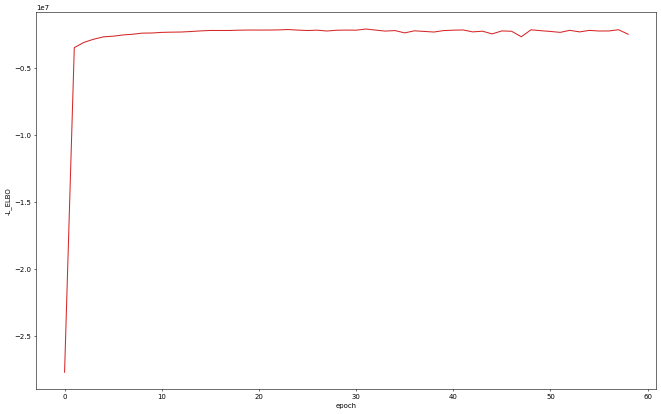

In [14]:
plot_loss_curve()

5. 32-dimensional latent space

In [88]:
code_size = 32
#then re-train model